# Определение перспективного тарифа для телеком компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент федерального оператора сотовой связи хочет понять, какой тариф приносит больше денег. Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

<font color='blue'>Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.<font>

**Описание данных**

**Таблица users (информация о пользователях):**

**user_id** — уникальный идентификатор пользователя

**first_name** — имя пользователя

**last_name** — фамилия пользователя

**age** — возраст пользователя (годы)

**reg_date** — дата подключения тарифа (день, месяц, год)

**churn_date** — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

**city** — город проживания пользователя

**tariff** — название тарифного плана

**Таблица calls (информация о звонках):**

**id** — уникальный номер звонка

**call_date** — дата звонка

**duration** — длительность звонка в минутах

**user_id** — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**

**id** — уникальный номер сообщения

**message_date** — дата сообщения

**user_id** — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

**id** — уникальный номер сессии

**mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах)

**session_date** — дата интернет-сессии

**user_id** — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**

**tariff_name** — название тарифа

**rub_monthly_fee** — ежемесячная абонентская плата в рублях

**minutes_included** — количество минут разговора в месяц, включённых в абонентскую плату

**messages_included** — количество сообщений в месяц, включённых в абонентскую плату

**mb_per_month_included** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

**rub_per_minute** — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

**rub_per_message** — стоимость отправки сообщения сверх тарифного пакета

**rub_per_gb** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Изучение общей информации

In [1]:
# Импортируем необходимые библиотеки:
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from functools import reduce
idx = pd.IndexSlice
from scipy import stats as st

#Импортируем данные:

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')


def dataset_info(data): # Для первичного ознакомления с ДатаСетом
    print(data.info())
    display(data.head())
    
for data in [users, calls, messages, internet, tariffs]:
    print('======= < DATASET > ===================================')
    print()
    dataset_info(data)
    print()
print('\nЧисло дубликатов:', data.duplicated().sum())


======= < DATASET > ===================================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra



======= < DATASET > ===================================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



======= < DATASET > ===================================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



======= < DATASET > ===================================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000



======= < DATASET > ===================================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra




Число дубликатов: 0


ВЫВОД: Датасет содержит данные по 500 клиентам, потребуется заменить тип данных у столбцов с датой и временем, а также округлить значения минут разговора и мегабайт использованного трафика в большую сторону, так как тарифы считаются по минутам и мегабайтам.

Кроме того, после объединения данных (сводная таблица по звонкам, по сообщениям и интернет-трафику) возникнут пропущенные значения (клиент мог в каком-то месяце не писать сообщений, но звонить и использовать интернет), которые также нужно будет заменить на нули.
Дубликатов нет,  сравнительно чистые данные.

### Подготовка данных

#### Приведение данных к нужным типам

In [2]:
#Каждую из 3 базовых вначале приведем даты к формату datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
#Добавим в каждую из 3 базовых таблиц с данными колонку с месяцем
calls['month'] = pd.to_datetime(calls['call_date']).dt.month
messages['month'] = pd.to_datetime(messages['message_date']).dt.month
internet['month'] = pd.to_datetime(internet['session_date']).dt.month

In [3]:
# выведем количество звонков равных нулю
print('Количество звонков с длительностью, равной нулю:', calls.loc[calls['duration'] == 0, 'duration'].value_counts()[0])

Количество звонков с длительностью, равной нулю: 39613


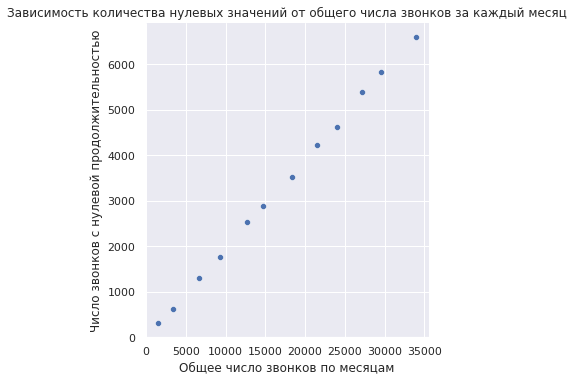

In [4]:
# построим график зависимости количества нулевых значений от общего числа звонков за каждый месяц
calls.loc[calls['duration'] == 0, 'nulls_count'] = 1
null_calls = calls.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_calls['null_ratio'] = round(null_calls['nulls_count'] / null_calls['id'], 3)

sns.relplot(x='id', y='nulls_count', data=null_calls)
plt.xlabel('Общее число звонков по месяцам')
plt.ylabel('Число звонков с нулевой продолжительностью')
_ = plt.title('Зависимость количества нулевых значений от общего числа звонков за каждый месяц')


Таким образом, доля звонков с нулевой продолжительностью стационарна, и их появление систематично. Округлим все значения в большую сторону (т.к. тариф считается по минутам), а нулевые значения заменим на 1.



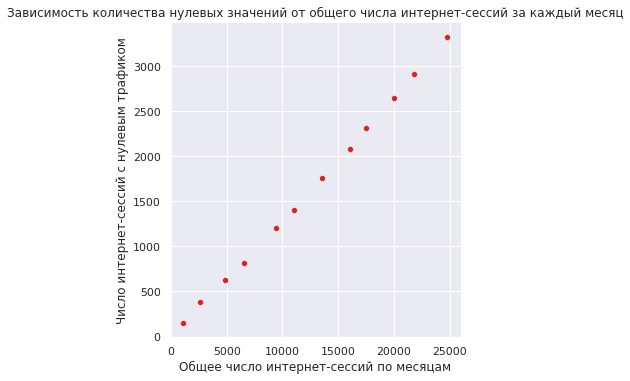

In [5]:
# интернет сессии
# построим график зависимости количества нулевых значений от общего числа интернет-сессий за каждый месяц
internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1
null_mb = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_mb['null_ratio'] = round(null_mb['nulls_count'] / null_mb['id'], 3)

sns.relplot(x='id', y='nulls_count', data=null_mb, color='tab:red')
plt.xlabel('Общее число интернет-сессий по месяцам')
plt.ylabel('Число интернет-сессий с нулевым трафиком')
_ = plt.title('Зависимость количества нулевых значений от общего числа интернет-сессий за каждый месяц')

Вывод по нулевым значениям интернет-сесссий аналогичен. Округлим все значения в большую сторону (т.к. тариф считается по мегабайтам), а нулевые значения заменим на 1.

ВЫВОД: Провели необходимые изменения типов данных.Перевод мб в гб в таблице с интернет-трафиком осуществим при дальнейшем анализе.

#### Нахождение и исправление ошибок 

Посчитайте для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [6]:
# для подсчета при создании сводной таблицы объединим  "users" в один "users name"
users['unique_name'] = users['city'] + users['first_name'] + users['last_name']

# сводная таблица по звонкам
calls_temp = calls.merge(users, on='user_id', how='inner')
calls_grouped = calls_temp.pivot_table(values=['unique_name', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']

# сводная таблица по сообщениям
messages['month'] = messages['message_date'].dt.month
messages_temp = messages.merge(users, on='user_id', how='inner')
messages_grouped = messages_temp.pivot_table(values='unique_name', 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count'})
messages_grouped.columns = ['messages']

# сводная таблица по интернет-трафику
internet['month'] = internet['session_date'].dt.month
internet_temp = internet.merge(users, on='user_id', how='inner')
internet_grouped = internet_temp.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
internet_grouped.columns = ['mb_used']

# объединяем все три сводные таблицы в одну
dfs = [calls_grouped, messages_grouped, internet_grouped]
grouped_data = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), dfs)
grouped_data.head(20)


duration  calls  messages   mb_used
user_id month                                     
1000    5        150.06   22.0      22.0   2253.49
        6        158.90   43.0      60.0  23233.77
        7        318.80   47.0      75.0  14003.64
        8        389.87   52.0      81.0  14055.93
        9        440.14   58.0      57.0  14568.91
        10       328.45   57.0      73.0  14702.49
        11       319.04   43.0      58.0  14756.47
        12       312.98   46.0      70.0   9817.61
1001    11       408.12   59.0       NaN  18429.34
        12       391.34   63.0       NaN  14036.66
1002    6        110.37   15.0       4.0  10856.82
        7        204.75   26.0      11.0  17580.10
        8        269.71   42.0      13.0  20319.26
        9        195.85   36.0       4.0  16691.08
        10       199.48   33.0      10.0  13888.25
        11       228.03   32.0      16.0  18587.28
        12       222.98   33.0      12.0  18113.73
1003    8        355.67   55.0      37.0   8565.21
        9        904.89  134.0      91.0  12468.87
        10       809.07  108.0      83.0  14768.14

In [7]:
len(grouped_data.reset_index()['user_id'].unique())

498

Как видим на 2 абонентов стало меньше (абоненты по которым не было ни звонков, ни смс, ни интернета), что в свою очередь не представляет для исследования интереса.

In [8]:
# пропущенные значения заменяем на нули
grouped_data.loc[grouped_data['duration'].isna(), 'duration'] = 0
grouped_data.loc[grouped_data['messages'].isna(), 'messages'] = 0
grouped_data.loc[grouped_data['mb_used'].isna(), 'mb_used'] = 0

grouped_data.head(20)   

duration  calls  messages   mb_used
user_id month                                     
1000    5        150.06   22.0      22.0   2253.49
        6        158.90   43.0      60.0  23233.77
        7        318.80   47.0      75.0  14003.64
        8        389.87   52.0      81.0  14055.93
        9        440.14   58.0      57.0  14568.91
        10       328.45   57.0      73.0  14702.49
        11       319.04   43.0      58.0  14756.47
        12       312.98   46.0      70.0   9817.61
1001    11       408.12   59.0       0.0  18429.34
        12       391.34   63.0       0.0  14036.66
1002    6        110.37   15.0       4.0  10856.82
        7        204.75   26.0      11.0  17580.10
        8        269.71   42.0      13.0  20319.26
        9        195.85   36.0       4.0  16691.08
        10       199.48   33.0      10.0  13888.25
        11       228.03   32.0      16.0  18587.28
        12       222.98   33.0      12.0  18113.73
1003    8        355.67   55.0      37.0   8565.21
        9        904.89  134.0      91.0  12468.87
        10       809.07  108.0      83.0  14768.14

In [9]:
# добавим наименование используемого тарифа для каждого пользователя
for user in grouped_data.index:
    grouped_data.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']

# функция подсчета выручки с каждого пользователя в месяц + добавление столбца доход (revenue), и группиррвка по нему.
def det_revenue(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

grouped_data['revenue'] = grouped_data.apply(det_revenue, axis=1)
grouped_data.head(10)

duration  calls  messages   mb_used tariff      revenue
user_id month                                                         
1000    5        150.06   22.0      22.0   2253.49  ultra  1950.000000
        6        158.90   43.0      60.0  23233.77  ultra  1950.000000
        7        318.80   47.0      75.0  14003.64  ultra  1950.000000
        8        389.87   52.0      81.0  14055.93  ultra  1950.000000
        9        440.14   58.0      57.0  14568.91  ultra  1950.000000
        10       328.45   57.0      73.0  14702.49  ultra  1950.000000
        11       319.04   43.0      58.0  14756.47  ultra  1950.000000
        12       312.98   46.0      70.0   9817.61  ultra  1950.000000
1001    11       408.12   59.0       0.0  18429.34  smart  1149.480469
        12       391.34   63.0       0.0  14036.66  smart   550.000000

ВЫВОД: Создали новую таблицу grouped_data - в которую сгруппировали данные по каждому абоненту за каждый месяц пользования. Заполнили образовавшиеся пропуски. Рассчитали для анализа 4 столбца: min - минут/мес, mes - СМС/мес, mb - МБ/мес и revenue - выручка за месяц. Таблица готова для анализа.

### Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [10]:
#Посчитаем, сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт в месяц
medians = grouped_data.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used', 'revenue'], aggfunc='median')
for user_id in users['user_id']:
    medians.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
medians.head(20)

,duration,mb_used,messages,revenue,tariff
user_id,,,,,
1000,318.920,14312.420,65.0,1950.000000,ultra
1001,399.730,16233.000,0.0,849.740234,smart
1002,204.750,17580.100,11.0,983.613281,smart
1003,775.390,11356.890,83.0,1950.000000,ultra
1004,123.935,17810.530,154.5,1950.000000,ultra
1005,562.525,7833.230,49.0,743.575000,smart
1006,332.320,15521.530,0.0,581.548828,smart
1007,447.990,14427.330,26.0,763.971406,smart
1008,320.840,13217.140,56.0,568.000000,smart


In [11]:
# более наглядно рассмотрим на распределение выручки внутри тарифа smart
smart_data = grouped_data.query('tariff == "smart"')
smart_data[['revenue']].describe()

,revenue
count,2229.000000
mean,1197.628537
std,767.611621
min,550.000000
25%,550.000000
50%,925.582031
75%,1603.029297
max,6542.875391


In [12]:
# более наглядно рассмотрим на распределение выручки внутри тарифа ultra
ultra_data = grouped_data.query('tariff == "ultra"')
ultra_data[['revenue']].describe()


,revenue
count,985.000000
mean,2059.868918
std,354.880790
min,1950.000000
25%,1950.000000
50%,1950.000000
75%,1950.000000
max,4736.966309


Средняя выручка тарифа smart равна 1197.6 руб, ст.откл. = 767.6 руб.
Cредняя выручка тарифа ultra равна 2059.8 руб, ст.откл. = 354.8 руб.
Из чего можно сделать предварительные выводы: 
 - средняя выручка ultra в 2 раза превышает smart абонентов,
 - абонентам smart в 2 раза чаще приходится выходить за рамки предоставленного тарифного пакета. Проверкой чего собственно и должно послужить тестирование основопологающей гипотезы.   

In [13]:
#Теперь найдем медиану, дисперсию и стандартное отклонение:
grouped_data.groupby('tariff')[['duration','mb_used','messages']].agg({'mean','var','std'}).style.format('{:.0f}')

Если стандартное отклонение по 3 параметрам различается между тарифами практически в 2 раза,то так же как и средний квадрат отклонений от среднего значения var (дисперсия) в тарифе Ultra превышает практически троекратно. Среднее (mean) звонков, интернет трафика и сообщений, обоих тарифов более сбалансированно.

 



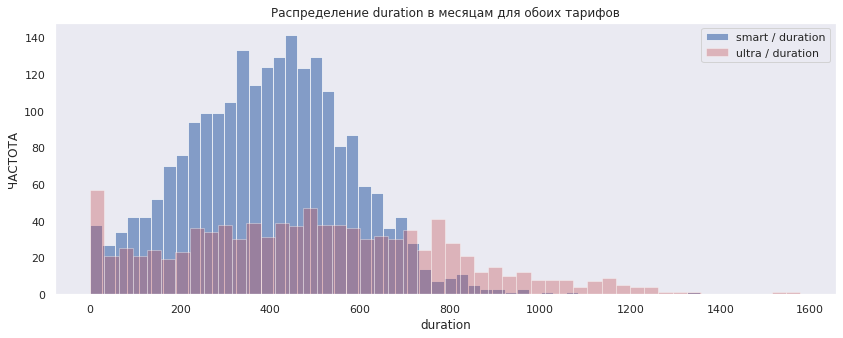

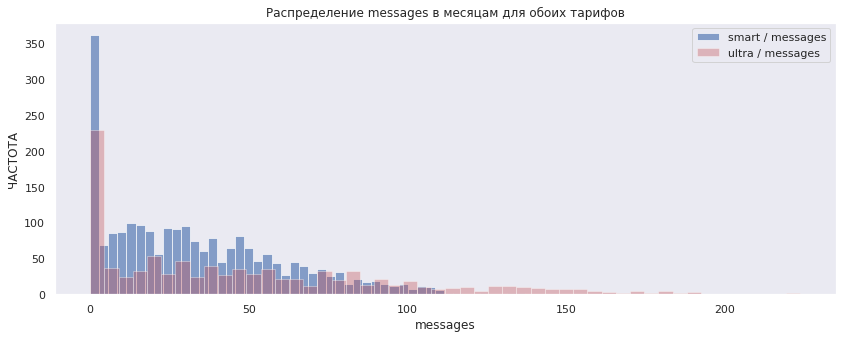

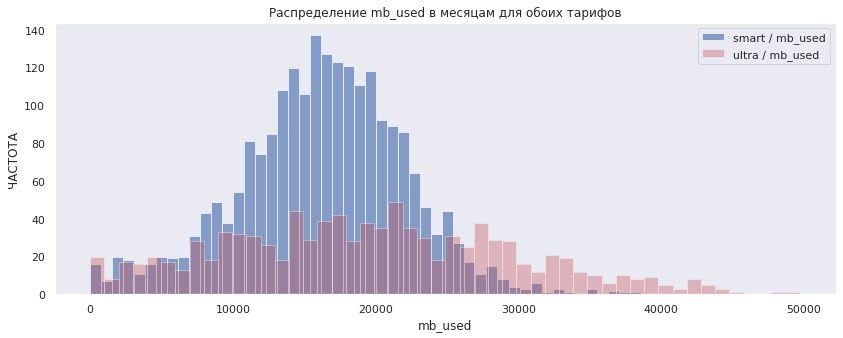

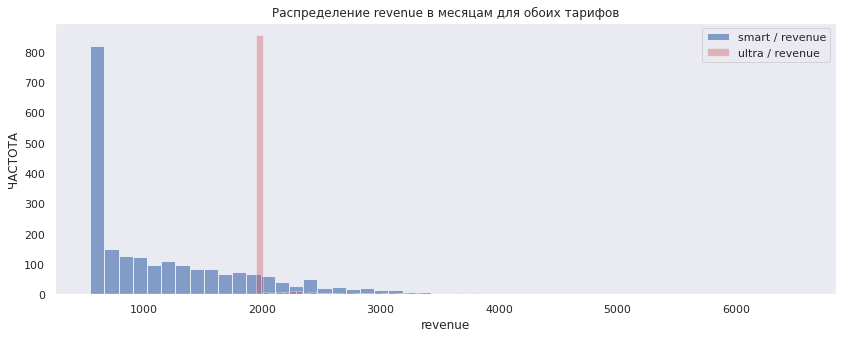

In [14]:
#Построим диаграммы размаха для каждого тарифа, а так же диаграмму распределения выручки.
for param in ['duration', 'messages', 'mb_used', 'revenue']:
    b = 50
    plt.figure(figsize=(14, 5))
    
    plt.hist(grouped_data.loc[grouped_data['tariff'] == "smart", param], label='smart / '+param, color='b', alpha=0.65, bins = b)
    plt.hist(grouped_data.loc[grouped_data['tariff'] == "ultra", param], label='ultra / '+param, color='r', alpha=0.35, bins = b)
    
    plt.ylabel('ЧАСТОТА')
    plt.xlabel(param)
    plt.grid()
    plt.title(f'Распределение {param} в месяцам для обоих тарифов')
    plt.legend()
    plt.show()

ВЫВОД: по гистограммам наглядно видно, что дисперсия по тарифу "Смарт" меньше, чем у пользователей с тарифом "Ультра" по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику. Также на гистограммах видно, что мода у "Смарта" явно выражена.

Другими словами, поведение пользователей тарифа "Ультра" более разнообразное с точки зрения потребления телекоммуникационных услуг. Пользователи дорогого тарифа более свободны в выборе того, как именно использовать объемы тарифного пакета.

В тарифе smart подавляющее большинство абонентов укладываются в лимит 500 минут разговора ( тарифе ultra не сильно ушли от этого значения - среднемесячное не больше 600 минут (не говоря уже об излишнем лимите в 1500). Также можно наблюдать, что расход минут постепенно возрастает в течение года. Исключение месяц февраль у тарифа ultra довольно сильное падение (хоть февраль самый короткий месяц, но снижение не пропорцианально - почти в 2 раза).

смс - мало популярная услуга (много абонентов которых вообще не пишут СМС или почти не пишут). Абоненты тарифа smart вполне укладываются в лимит 50 СМС (а среднее 28 СМС в месяц за год), даже абоненты тарифа ultra редко превышают порог в 50 СМС (за исключением 200 smart и 350 ultra возможно какие-то магазины). В тарифе smart в первой половине года активность постепенно возрастает, а во второй уменьшается.В ultra так же идет угасание ко второй половине года - в более меньшем объеме, но более продолжительно.

С интернет-трафиком другая ситуация. Абоненты smart любят посидеть в интернете и частенько привышают лимитв 15000 МБ, также надо отметить, что опять начало года (январь и февраль) характеризовано низкой активностью в интернете. В тарифе ultra онизкие значения в начале года, а в остально часть года идет  постепенный рост и держится стабильное состояние.

По выручке можно сказать: что выручка абонентов ultra в подавляющем большинстве случаев ограничивается абонплатой (1950р), а абоненты smart напротив очень частенько платят сверх абонплаты ( 1197.6 средн и станд. 767.6, при  абонплате =  550р  - и все это за счет интернет трафика) 

### Проверка гипотез

**Гипотеза №1:** средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.



H0  — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

H1  — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

α=1%

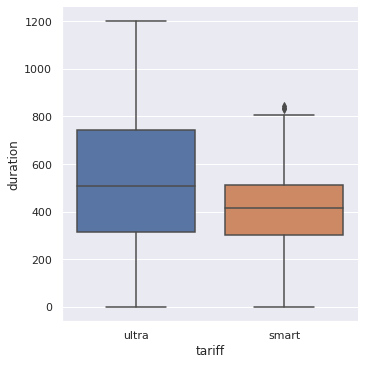

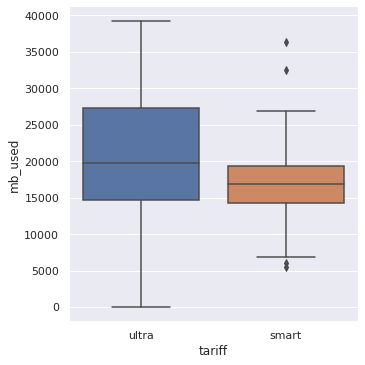

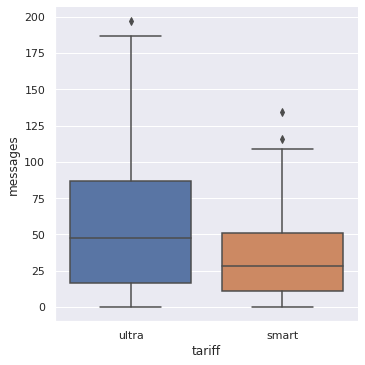

In [15]:
# для анализа распределения используем boxplot, так как выборка не слишком велика 
for column in ['duration', 'mb_used', 'messages']:    
    sns.catplot(x="tariff", y=column, kind="box", data=medians, orient='v')

Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт», и медианы по вышеперечисленным признакам также смещены в большую сторону. Кроме того, выбросов в рамках более дешевого тарифа существенно больше.
Изходя из вышеописанного для проверки 1 и 2 гипотезы будем использовать 2-х выборочный t- test (так как дисперсии выборок явно не равны). Заявим alpha = .01

In [16]:
#используем 2-х выборочный t- test 
from scipy import stats
rng = np.random.default_rng()
ultra = grouped_data.query('tariff == "ultra"')['revenue']
smart = grouped_data.query('tariff == "smart"')['revenue']

alpha = .01

results = stats.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


In [17]:
# выведим итоговую выручку по обоим тарифам 
grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='median')

,revenue
tariff,
smart,925.582031
ultra,1950.000000


ВЫВОД: 
 Можно подтвердить, что мы отклоняем нулевую гипотезу - средняя выручка пользователей тарифа "Ультра" отличается статистически значимо от средней выручки пользователей тарифа "Смарт", т.е. есть статистически значимая разница между ними .(Если у пользователя подключен тариф "Смарт" с абонентской платой в 550 рублей, то он скорее всего по итогам месяца заплатит гораздо больше из-за нехватки услуг в рамках тарифного пакета).

**Гипотеза №2:** средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. (используем аналогию 1 гипотезы)


H0  — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

H1  — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

α=1%

In [18]:
# добавим наименование населенного пункта для каждого пользователя
#используем 2-х выборочный t- test
for user in grouped_data.index:
    grouped_data.loc[user, 'city'] = users.loc[user[0]-1000, 'city']

moscow = grouped_data.query('city == "Москва"')['revenue']
regions = grouped_data.query('city != "Москва"')['revenue']

alpha = .01

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.39315549330104205
Не получилось отвергнуть нулевую гипотезу


In [19]:
# добавим наименование населенного пункта для каждого пользователя
def det_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
# выведим итоговую выручку по обоим тарифам     
grouped_data['region'] = grouped_data['city'].apply(det_region)
grouped_data.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другой регион,1471.230469
Москва,1638.054688


ВЫВОД: 
Данный статистический тест не дал возможности опровергунть исходную гипотезу о том, что доходы от пользователей из Москвы и из других регионов равны. Действительно, доходы в Московском регионе практически не отличаются от других населенных пунктов. нулевая гипотеза принимается и что средняя выручка не отличается статистически значимо, т.е. нет статистически значимой разницы между двумя выборками)



### Общий вывод

**Общий вывод
В ходе исследования были проверены 2 гипотезы:

* Гипотеза №1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается: ГИПОТЕЗА ПОДТВЕРДИЛАСЬ
* Гипотеза №2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов: ГИПОТЕЗА НЕ ПОДТВЕРДИЛАСЬ.

Отвечая на вопрос ииследования, можно рекомендовать оператору продвигать тариф Ультра. 

Так как наш тест подвердил, что  средняя выручка пользователей тарифов Ультра и Смарт различаются (а именно средняя выручка тарифа Ультра в 2 раза превышает выручку Смарт, где определяющим условием так же является то, абонентам второго не хватает услуг в рамках тарифного пакета).
